In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
from scipy.stats import cauchy
from scipy import signal

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Sizing Fabry Perot Interferometer

| Quantum dot emission            | Energy           | Frequency  |
|----------------|------------------|-----------------------------|
| Center         | (1.38 - 2.07) eV | (3.33 - 5.00) $10^{14}$ Hz  |
| Spectral range | (100 - 500) µeV   | (24.20 - 120.90) $10^9$ Hz |

ThorLab-mirrors are available with R = 93%, these should be a suitable starting point for the calculation:

In [3]:
R_1 = R_2 = 0.93

In [4]:
v_dot_spectral_range_lower = 24.20 * 10**9
v_dot_spectral_range_upper = 120.90 * 10**9

The free spectral range $\Delta \nu_{\rm FSR}$ is given by
$$\Delta \nu_{\rm FSR} = \frac{c}{2l}$$
where $c$ is the speed of light in the medium and $l$ is geometrical length of the two mirror Fabry-Pérot.

The free spectral range $\Delta \nu_{\rm FSR}$ of the Fabry-Perot needs to greater than the spectral range of the quantum dot emission.

Therefore I assume two values for the two extremes of the spectral ranges of the dot with a buffer:

In [5]:
buffer = 10
delta_v_FSR_lower = v_dot_spectral_range_lower * buffer
delta_v_FSR_upper = v_dot_spectral_range_upper * buffer

l_lower = constants.c / (2 * delta_v_FSR_lower)
l_upper = constants.c / (2 * delta_v_FSR_upper)

print(f"l_lower = {l_lower * 10**3:.02f} mm")
print(f"l_upper = {l_upper * 10**3:.02f} mm")

l_lower = 0.62 mm
l_upper = 0.12 mm


 The FWHM linewidth $\Delta \nu_{\rm Airy}$ of the Airy distribution is given by

$$\Delta \nu_{\rm Airy} = \Delta \nu_{\rm FSR} \frac{2}{\pi} \arcsin \left( \frac{1 - \sqrt{R_1 R_2}}{2 \sqrt[4]{R_1 R_2}} \right)$$

In [6]:
def calc_delta_v_Airy(delta_v_FSR, R_1, R_2):
    return delta_v_FSR * 2 / np.pi * np.arcsin((1-np.sqrt(R_1*R_2))/(2*(R_1 * R_2)**(1/4)))

In [7]:
delta_v_Airy_lower = calc_delta_v_Airy(delta_v_FSR_lower, R_1, R_2)
delta_v_Airy_upper = calc_delta_v_Airy(delta_v_FSR_upper, R_1, R_2)

print(f"delta_E_Airy_lower = {delta_v_Airy_lower * constants.h / constants.e * 10**6:.02f} µeV")
print(f"delta_E_Airy_upper = {delta_v_Airy_upper * constants.h / constants.e * 10**6:.02f} µeV")

delta_E_Airy_lower = 23.13 µeV
delta_E_Airy_upper = 115.55 µeV


$$A'_{trans}(\nu)=\frac{(1-R_1)(1-R_2)}{(1-\sqrt{R_1R_2})^2+4\sqrt{R_1R_2}\sin^2(\phi)}$$

with

$$\phi(\nu)=\frac{\pi\nu}{\Delta \nu_{FSR}}$$

In [8]:
def delta_v_FSR(l):
    return constants.c / (2*l)


def phi(v, l):
    return constants.pi * v / delta_v_FSR(l)


def A_prime_trans(v, R_1, R_2, l):
    return (1-R_1) * (1-R_2) / ((1-np.sqrt(R_1*R_2))**2+4*np.sqrt(R_1*R_2)*np.sin(phi(v,l))**2)

### Goal:
Resolve QDs with paramters seen in table at the top.

Describe dot spectrum with cauchy distribution.

$$\Phi_{dot}(\nu) = \frac{1}{\pi \cdot v\_dot\_spectral\_range \cdot 0.5 \left[1+\left(\frac{\nu - \nu\_dot\_center}{v\_dot\_spectral\_range \cdot 0.5}\right)^2\right]}$$

In [9]:
def dot_spectrum(v, v_dot_center, v_dot_spectral_range):
    return cauchy.pdf(v, loc=v_dot_center, scale=v_dot_spectral_range * 0.5)

In [10]:
v_dot_center = 4 * 10**14 # in Hz
number_of_points = 4000
number_of_airy_peaks = 4

v_boundaries_lower = (v_dot_center - delta_v_FSR(l_lower)*number_of_airy_peaks/2, v_dot_center + delta_v_FSR(l_lower)*number_of_airy_peaks/2)
v_boundaries_upper = (v_dot_center - delta_v_FSR(l_upper)*number_of_airy_peaks/2, v_dot_center + delta_v_FSR(l_upper)*number_of_airy_peaks/2)

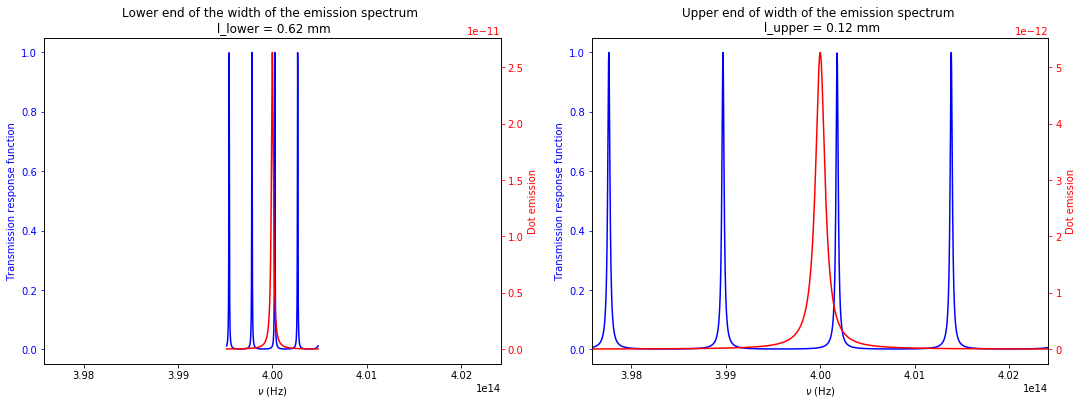

In [11]:
fig, (ax1_lower, ax1_upper) = plt.subplots(1, 2)
fig.set_size_inches(18, 6)

V_lower = np.linspace(*v_boundaries_lower, number_of_points)

ax1_lower.plot(V_lower, A_prime_trans(V_lower, R_1, R_2, l_lower), "b")
ax1_lower.set_xlim(v_boundaries_upper)
ax1_lower.set_xlabel(r"$\nu$ (Hz)")
ax1_lower.set_ylabel("Transmission response function", color="b")
ax1_lower.tick_params("y", colors="b")
ax1_lower.set_title(f"Lower end of the width of the emission spectrum \n l_lower = {l_lower * 10**3:.02f} mm")

ax2_lower = ax1_lower.twinx()
ax2_lower.plot(V_lower, dot_spectrum(V_lower, v_dot_center, v_dot_spectral_range_lower), "r")
ax2_lower.set_ylabel("Dot emission", color="r")
ax2_lower.tick_params("y", colors="r")

V_upper = np.linspace(*v_boundaries_upper, number_of_points)

ax1_upper.plot(V_upper, A_prime_trans(V_upper, R_1, R_2, l_upper), "b")
ax1_upper.set_xlim(v_boundaries_upper)
ax1_upper.set_xlabel(r"$\nu$ (Hz)")
ax1_upper.set_ylabel("Transmission response function", color="b")
ax1_upper.tick_params("y", colors="b")
ax1_upper.set_title(f"Upper end of width of the emission spectrum \n l_upper = {l_upper * 10**3:.02f} mm")

ax2_upper = ax1_upper.twinx()
ax2_upper.plot(V_upper, dot_spectrum(V_upper, v_dot_center, v_dot_spectral_range_upper), "r")
ax2_upper.set_ylabel("Dot emission", color="r")
ax2_upper.tick_params("y", colors="r")

The output-photon-flux of the scanning Fabry-Perot-interferometer is described with the convolution of the emission of the QD $E_{dot}(\nu)$ and the transmission of the Fabry-perot $A'_{trans}(\nu)$.

$$\Phi_{fabry,perot, unnormalized} = \int^{v\_dot\_center + \Delta \nu_{FSR} \cdot number\_of\_airy\_peaks}_{v\_dot\_center - \Delta \nu_{FSR} \cdot number\_of\_airy\_peaks} d\nu' E_{dot}(\nu')A'_{trans}(\nu - \nu')$$

it can then be normalized with the integral of $A'_{trans}(\nu)$ over one period:

$$normalization\_factor = \int^{v\_dot\_center + \Delta \nu_{FSR} \cdot number\_of\_airy\_peaks \cdot 0.5}_{v\_dot\_center - \Delta \nu_{FSR} \cdot number\_of\_airy\_peaks \cdot 0.5} d\nu A'_{trans}(\nu) = \frac{\sum A'_{trans}(\nu)}{number\_of\_airy\_peaks} $$

Therefore the output-photon-flux of the scanning Fabry-Perot-interferometer is:
$$\Rightarrow \Phi_{fabry,perot} = \frac{\Phi_{fabry,perot, unnormalized}}{normalization\_factor}$$

In [12]:
phi_fabry_perot_unnormalized_lower = signal.convolve(dot_spectrum(V_lower, v_dot_center, v_dot_spectral_range_lower), A_prime_trans(V_lower, R_1, R_2, l_lower))
normalization_factor_lower = sum(A_prime_trans(V_lower, R_1, R_2, l_lower)) / number_of_airy_peaks
phi_fabry_perot_lower = phi_fabry_perot_unnormalized_lower / normalization_factor_lower

v_conv_boundaries_lower = (v_dot_center - delta_v_FSR(l_lower)*number_of_airy_peaks, v_dot_center + delta_v_FSR(l_lower)*number_of_airy_peaks)
V_2_lower = np.linspace(*v_conv_boundaries_lower, number_of_points*2-1)

phi_fabry_perot_unnormalized_upper = signal.convolve(dot_spectrum(V_upper, v_dot_center, v_dot_spectral_range_upper), A_prime_trans(V_upper, R_1, R_2, l_upper))
normalization_factor_upper = sum(A_prime_trans(V_upper, R_1, R_2, l_upper)) / number_of_airy_peaks
phi_fabry_perot_upper = phi_fabry_perot_unnormalized_upper / normalization_factor_upper

v_conv_boundaries_upper = (v_dot_center - delta_v_FSR(l_upper)*number_of_airy_peaks, v_dot_center + delta_v_FSR(l_upper)*number_of_airy_peaks)
V_2_upper = np.linspace(*v_conv_boundaries_upper, number_of_points*2-1)

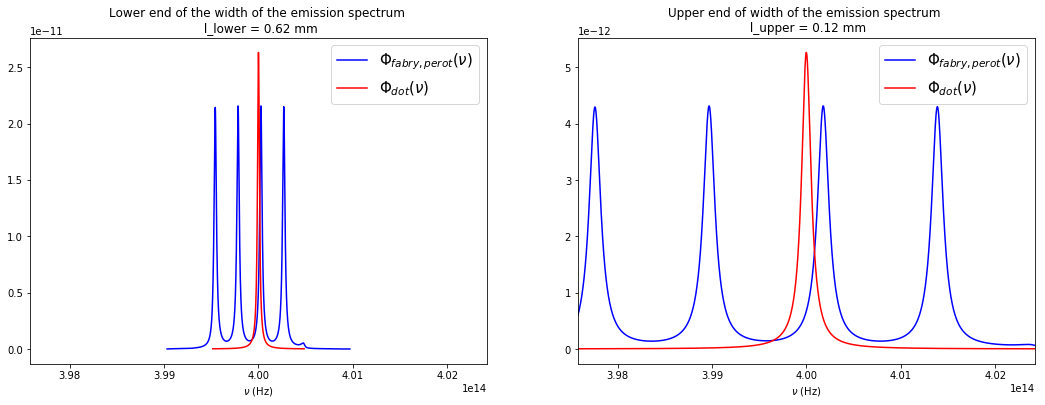

In [13]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(V_2_lower, phi_fabry_perot_lower, "b", label=r"$\Phi_{fabry,perot}(\nu)$")
plt.plot(V_lower, dot_spectrum(V_lower, v_dot_center, v_dot_spectral_range_lower), "r" , label=r"$\Phi_{dot}(\nu)$")
plt.xlabel(r"$\nu$ (Hz)")
plt.xlim(v_boundaries_upper)
plt.legend(fontsize=15)
plt.title(f"Lower end of the width of the emission spectrum \n l_lower = {l_lower * 10**3:.02f} mm")

plt.subplot(1, 2, 2)
plt.plot(V_2_upper, phi_fabry_perot_upper, "b", label=r"$\Phi_{fabry,perot}(\nu)$")
plt.plot(V_upper, dot_spectrum(V_upper, v_dot_center, v_dot_spectral_range_upper), "r" , label=r"$\Phi_{dot}(\nu)$")
plt.xlabel(r"$\nu$ (Hz)")
plt.xlim(v_boundaries_upper)
plt.legend(fontsize=15)
plt.title(f"Upper end of width of the emission spectrum \n l_upper = {l_upper * 10**3:.02f} mm")

plt.show()

To better compare $\Phi_{dot}(\nu)$ and $\Phi_{fabry,perot}$, we need to shift them relative to each other:

In [14]:
position_airy_peak = signal.find_peaks(phi_fabry_perot)[0][0]
position_dot_peak = signal.find_peaks(dot_spectrum(V, v_dot_center, v_dot_spectral_range))[0][0]

phi_fabry_perot_shifted = np.roll(phi_fabry_perot, position_dot_peak - position_airy_peak)

NameError: name 'phi_fabry_perot' is not defined

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(V_2, phi_fabry_perot_shifted, "b", label=r"$\Phi_{fabry,perot}(\nu)$")
plt.plot(V, dot_spectrum(V, v_dot_center, v_dot_spectral_range), "r" , label=r"$\Phi_{dot}(\nu)$")
plt.xlabel(r"$\nu$ (Hz)")
plt.xlim(v_boundaries)
plt.legend(fontsize=15)
plt.show()